# Assignment 2

Name        : Chia Sin Liew   
Last edited : March 31st, 2022 

The goal of this assignment is to solve regression and classification problems using following models.

- **Part A**: Regression Problem – Linear Regression using the Stochastic Gradient Descent algorithm
- **Part B**: Classification Problem – K-Nearest Neighbors

## Part A: Linear Regression using SGD

You will perform regression on the following dataset using the Polynomial Regression Model with the Stochastic Gradient Descent (SGD) algorithm (use Scikit-Learn implementation). 

Your goal is to:

- Minimize the Test dataset’s Mean Squared Error
- Maximize the Test dataset’s Coefficient of determination R2 variance score

### **Dataset**:
The energy efficiency dataset *EnergyEfficiency.xlsx* is created to perform energy analysis. The dataset comprises 768 samples and 8 features (X1 to X8). It has two real valued target variables (Y1 and Y2), i.e., heating load and cooling load, respectively.

- X1: Relative Compactness
- X2: Surface Area
- X3: Wall Area
- X4: Roof Area
- X5: Overall Height
- X6: Orientation
- X7: Glazing Area
- X8: Glazing Area Distribution
- Y1: Heating Load
- Y2: Cooling Load

For this task you will **only predict the heating load**. Thus, use **Y1** as the label.

In [1]:
import pandas as pd
import os, sys 
import numpy as np
import warnings

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

### **Pre-Processing**:

- Load the .xlsx file as a Pandas DataFrame object. You may use pandas read_excel() method.

In [2]:
df = pd.read_excel("Dataset-Assignment2/EnergyEfficiency.xlsx")
df

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
...,...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48,16.61


- Create a separate feature set (Data Matrix X) and target (1D Array y).

In [14]:
def create_feature_target_arrays(df, target, drop_columns):
    # y for target
    y = df[target].to_frame()
    # X for features
    X = df.drop(columns=drop_columns)

    print("\nData frame for features(X): \n", X.head())
    print("\nDimension of X: ", X.shape)
    print("\nData frame for target(Y): \n", y)
    print("\nDimension of Y: ", y.shape)

    # convert into np arrays
    X = np.asarray(X)
    y = np.asarray(y).ravel()

    print("\nX data type: ", X.dtype)
    print("Y data type: ", y.dtype)
    
    return(X, y)


X, y = create_feature_target_arrays(df, "Y1", ["Y1", "Y2"])


Data frame for features(X): 
      X1     X2     X3      X4   X5  X6   X7  X8
0  0.98  514.5  294.0  110.25  7.0   2  0.0   0
1  0.98  514.5  294.0  110.25  7.0   3  0.0   0
2  0.98  514.5  294.0  110.25  7.0   4  0.0   0
3  0.98  514.5  294.0  110.25  7.0   5  0.0   0
4  0.90  563.5  318.5  122.50  7.0   2  0.0   0

Dimension of X:  (768, 8)

Data frame for target(Y): 
         Y1
0    15.55
1    15.55
2    15.55
3    15.55
4    20.84
..     ...
763  17.88
764  16.54
765  16.44
766  16.48
767  16.64

[768 rows x 1 columns]

Dimension of Y:  (768, 1)

X data type:  float64
Y data type:  float64


- Partition the data in training & test subsets (80% - 20%).

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(614, 8)
(154, 8)
(614,)
(154,)


In [17]:
# Create a data frame for feature selection through correlation analysis
df_train = pd.DataFrame(np.concatenate((X_train, np.reshape(y_train, (614, 1))), axis=1), 
                      columns=['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'Y1'])
df_train

,X1,X2,X3,X4,X5,X6,X7,X8,Y1
0,0.86,588.0,294.0,147.00,7.0,5.0,0.40,4.0,32.75
1,0.71,710.5,269.5,220.50,3.5,2.0,0.25,1.0,12.57
2,0.62,808.5,367.5,220.50,3.5,5.0,0.40,3.0,16.74
3,0.98,514.5,294.0,110.25,7.0,2.0,0.10,3.0,24.28
4,0.98,514.5,294.0,110.25,7.0,3.0,0.25,4.0,28.55
...,...,...,...,...,...,...,...,...,...
609,0.64,784.0,343.0,220.50,3.5,3.0,0.40,4.0,19.13
610,0.74,686.0,245.0,220.50,3.5,2.0,0.10,3.0,10.39
611,0.64,784.0,343.0,220.50,3.5,3.0,0.10,3.0,15.36
612,0.69,735.0,294.0,220.50,3.5,5.0,0.00,0.0,6.81


- Feature Selection: For optimal test performance, you may use a subset of features. However, it’s up to you to decide which features to select or to keep all
features.

In [18]:
# calculate Pearson's correlation
corr_threshold = 0.2

feature_corr = df_train.corr()["Y1"].sort_values(ascending=False)
print(feature_corr)

# Keep features above the selected threshold
print("\nKeep:\n")
retained_features = feature_corr[feature_corr.abs() >= corr_threshold]
print(retained_features)

# subset df
df_sub = df_train.loc[:, sorted(retained_features.index.to_list())]
df_sub

Y1    1.000000
X5    0.889144
X1    0.632955
X3    0.425035
X7    0.248738
X8    0.087487
X6    0.007846
X2   -0.667584
X4   -0.860543
Name: Y1, dtype: float64

Keep:

Y1    1.000000
X5    0.889144
X1    0.632955
X3    0.425035
X7    0.248738
X2   -0.667584
X4   -0.860543
Name: Y1, dtype: float64


,X1,X2,X3,X4,X5,X7,Y1
0,0.86,588.0,294.0,147.00,7.0,0.40,32.75
1,0.71,710.5,269.5,220.50,3.5,0.25,12.57
2,0.62,808.5,367.5,220.50,3.5,0.40,16.74
3,0.98,514.5,294.0,110.25,7.0,0.10,24.28
4,0.98,514.5,294.0,110.25,7.0,0.25,28.55
...,...,...,...,...,...,...,...
609,0.64,784.0,343.0,220.50,3.5,0.40,19.13
610,0.74,686.0,245.0,220.50,3.5,0.10,10.39
611,0.64,784.0,343.0,220.50,3.5,0.10,15.36
612,0.69,735.0,294.0,220.50,3.5,0.00,6.81


In [19]:
# Convert the selected features data frame into numpy arrays
X_train, y_train = create_feature_target_arrays(df_sub, "Y1", ["Y1"])

# Also subset the selected features for X_test
X_test = X_test[:, [0, 1, 2, 3, 4, 6]]

# Check dimensions of all data
print("\nData dimension: ")
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


Data frame for features(X): 
      X1     X2     X3      X4   X5    X7
0  0.86  588.0  294.0  147.00  7.0  0.40
1  0.71  710.5  269.5  220.50  3.5  0.25
2  0.62  808.5  367.5  220.50  3.5  0.40
3  0.98  514.5  294.0  110.25  7.0  0.10
4  0.98  514.5  294.0  110.25  7.0  0.25

Dimension of X:  (614, 6)

Data frame for target(Y): 
         Y1
0    32.75
1    12.57
2    16.74
3    24.28
4    28.55
..     ...
609  19.13
610  10.39
611  15.36
612   6.81
613  41.30

[614 rows x 1 columns]

Dimension of Y:  (614, 1)

X data type:  float64
Y data type:  float64

Data dimension: 
(614, 6)
(154, 6)
(614,)
(154,)


### **Experiments**:

-**Experiment 1**. Create an optimal Polynomial Regression model and train it using SGD with optimal hyperparameters. For the SGD based model selection, see the following notebook: https://github.com/rhasanbd/Linear-Regression-Extensive-Adventure/blob/master/Linear%20Regression-5-Polynomial%20SGD%20Regressor%20Model%20Selection.ipynb


In [8]:
%%time
warnings.filterwarnings('ignore') 

# Model Selection
# Create a Pipeline object
sgd_pipeline = Pipeline([
    # Bias should be excluded because by default SGDRegressor adds bias via 
    # the "fit_intercept" parameter
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('sgd', SGDRegressor(penalty='elasticnet')),
])

# Create a dictionary object with hyperparamters as keys and lists of corresponding values
param_grid = {
    'poly__degree': [1, 2, 3, 4, 5],
    'sgd__alpha': [0.1, 0.01, 0.001, 0.0001],
    'sgd__l1_ratio': [1, 0.7, 0.5, 0.2, 0],
    'sgd__max_iter': [500, 1000],
    'sgd__eta0': [0.01, 0.001, 0.0001]
}


# Create a GridSearchCV object and perform hyperparameter tuning
sgd = GridSearchCV(sgd_pipeline, param_grid, scoring='neg_mean_squared_error', 
                       cv=3, verbose=1, n_jobs=-1)
    
def run_fit_without_warning():
    if not sys.warnoptions:
        warnings.simplefilter("ignore")
        os.environ["PYTHONWARNINGS"] = "ignore"
        # The model is trained with optimal hyperparamters, thus it's the optimal model
        sgd.fit(X_train, y_train)
        return sgd

sgd = run_fit_without_warning()

# Get the optimal hyperparameters
params_optimal_sgd = sgd.best_params_

print("\nBest Score (negative mean squared error): %f" % sgd.best_score_)
print("\nOptimal Hyperparameter values: ", params_optimal_sgd)
print("\n")

Fitting 3 folds for each of 600 candidates, totalling 1800 fits

Best Score (negative mean squared error): -4.586243

Optimal Hyperparameter values:  {'poly__degree': 5, 'sgd__alpha': 0.01, 'sgd__eta0': 0.01, 'sgd__l1_ratio': 0.2, 'sgd__max_iter': 500}


CPU times: user 1.82 s, sys: 171 ms, total: 1.99 s
Wall time: 29.6 s


- Report: degree of the optimal polynomial model and following results for both training and test data: Mean Squared Error & Coefficient of determination R2 variance score

In [9]:
# Model Evaluation

# Training data: Make prediction 
y_train_predicted_sgd = sgd.predict(X_train)

print("Train: Mean squared error: %.2f"
      % mean_squared_error(y_train, y_train_predicted_sgd))

# Training data: Explained variance score: 1 is perfect prediction
print("Train: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_train, y_train_predicted_sgd))

# Test data: Make prediction 
y_test_predicted = sgd.predict(X_test)

print("\nTest: Mean squared error: %.2f"
      % mean_squared_error(y_test, y_test_predicted))

# Training data: Explained variance score: 1 is perfect prediction
print("Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_test, y_test_predicted))

Train: Mean squared error: 4.43
Train: Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.96

Test: Mean squared error: 4.40
Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.96


- Create a learning curve (negative MSE vs train/validation data) using the optimal model. See how this can be done from block 14 of the following notebook: https://github.com/rhasanbd/Linear-Regression-Extensive-Adventure/blob/master/Linear%20Regression-2-OLS%20Polynomial%20Regression-Frequentist%20Approach.ipynb

No. of Original Features:  6
No. of Augmented Features:  461


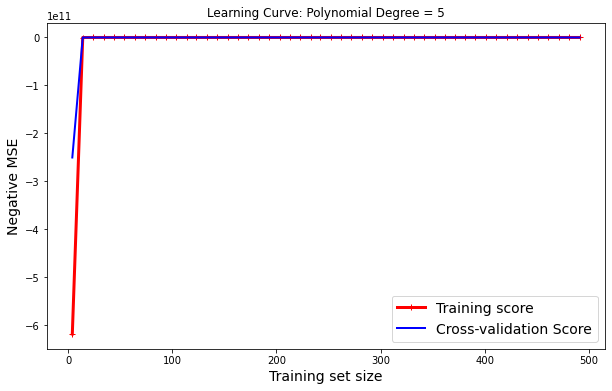

In [10]:
# Learning curve

# Variable that specifies the degree of the polynomial to be added
# to the feature vector
poly_degree = params_optimal_sgd['poly__degree'] 


# Add polynomial and bias term with the feature vector 
# using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)


print("No. of Original Features: ", X_train.shape[1])
print("No. of Augmented Features: ", X_train_poly.shape[1])


scaler = StandardScaler().fit(X_train_poly)
X_train_poly_standardized = scaler.transform(X_train_poly)


# get optimal hyperparameters
alpha = params_optimal_sgd['sgd__alpha']
l1_ratio = params_optimal_sgd['sgd__l1_ratio']
max_iter = params_optimal_sgd['sgd__max_iter']
eta0 = params_optimal_sgd['sgd__eta0']


# Create a learning curve
train_sizes, train_scores, val_scores = learning_curve(SGDRegressor(penalty='elasticnet', alpha=alpha, 
                                                                   l1_ratio=l1_ratio, max_iter=max_iter, 
                                                                    eta0=eta0), 
                                                       X_train_poly_standardized, 
                                                       y_train, cv=5, scoring='neg_mean_squared_error', 
                                                       train_sizes=np.linspace(0.01, 1.0, 50),
                                                       n_jobs=-1)


# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of validation set scores
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, "r-+", linewidth=3, label="Training score")
plt.plot(train_sizes, val_mean, "b-", linewidth=2, label="Cross-validation Score")
plt.legend(loc="best", fontsize=14)
plt.xlabel("Training set size", fontsize=14)
plt.ylabel("Negative MSE", fontsize=14)
plt.title("Learning Curve: Polynomial Degree = %d" % poly_degree)
plt.show()

Answer the following question.
- Q-1) What does the learning curve tell you? Is your model underfitting or overfitting? Does it have high/low bias and high/low variance? Justify your answer.

In general, the model is as good as it can be - as can be seen from the high R2 of 0.96 for both training and testing data. The MSEs for both train and test data are similar at about 4.4, which points to a well-performed model.

For the learning curve, the training data starts with relatively large negative RMSEs when few instances are used for training and with increasing number of training instances, first sharply, then gradually becoming closer to zero with the increasing number of instances and overcoming the noise, until eventually reaching a plateau of about -5 even when more data are added.

Likewise, the validation data shows a similar trend as the training data, albeit starting with smaller negative RMSEs, and also reaches a plateau of about -5 as well like the training curve.

In short, the training and validation curves converge and reach a plateau at about -5 negative RMSE with increasing number of training instances. The model is still very slightly underfitting, therefore having a high bias, because the negative RMSEs for both training and testing data are not zero, but it is the best complex model for a SGD linear regression solution, for this particular data set.
